<a href="https://colab.research.google.com/github/marreapato/Deep_Learning_Course/blob/main/MOdified_BiLSTM_Baseline_Com_Lags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tentando Aplicar o Shap

In [ ]:
# !pip install yfinance
# ! pip install tensorflow
# !pip install statsmodels

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, GRU# captum (biblioteca de interpretação pytorch)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Download data for the stock (I'm using the Bovespa index as an example)
# data = yf.download('^BVSP', '2007-01-01', '2023-10-17')
# Download data for the stock (I'm using the Bovespa index as an example)
data = yf.download('^BVSP', '2007-01-01', '2023-10-17')
data = data[['Close']]


[*********************100%%**********************]  1 of 1 completed


In [ ]:
data.shape

(4154, 1)

In [ ]:
data.head()#.values.reshape(-1,1) #45383. 116534.

,Close
Date,
2007-01-02,45383.0
2007-01-03,44445.0
2007-01-04,44020.0
2007-01-05,42245.0
2007-01-08,42830.0


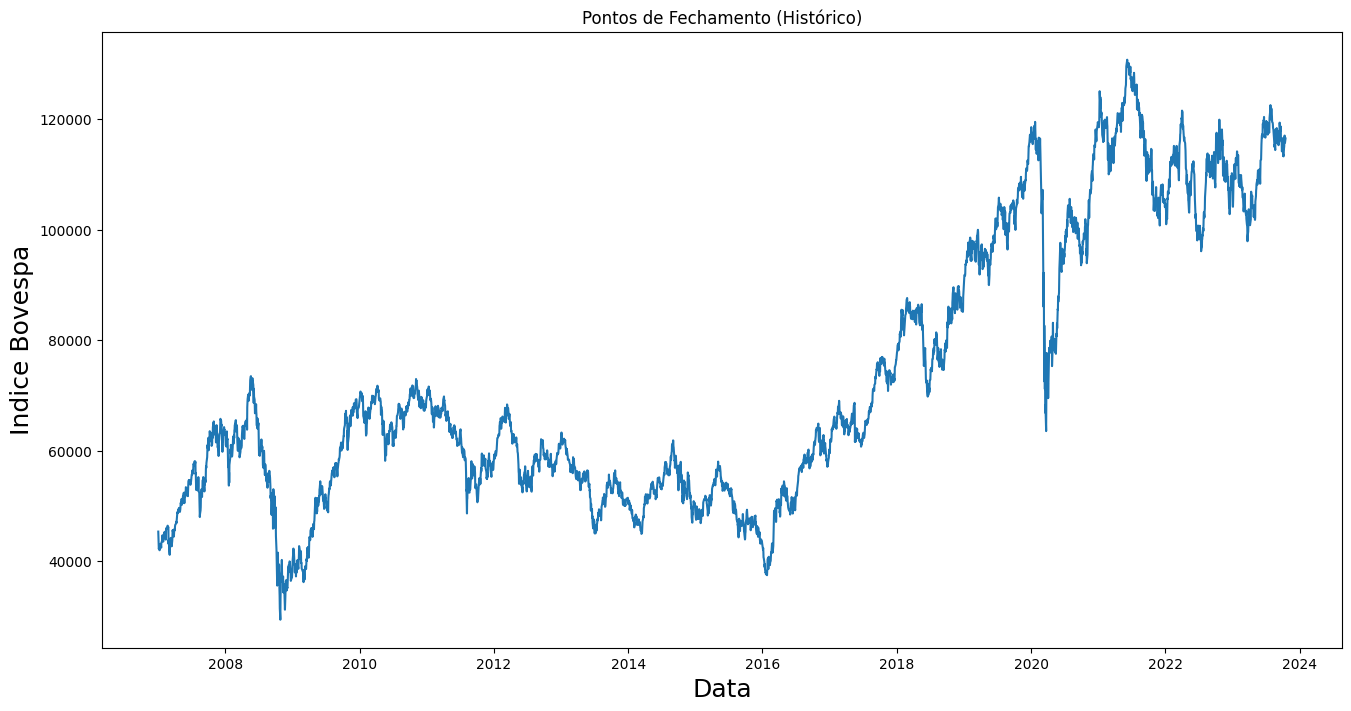

In [ ]:
plt.figure(figsize=(16,8))
plt.title("Pontos de Fechamento (Histórico)")
plt.plot(data["Close"])
plt.xlabel("Data",fontsize=18)
plt.ylabel("Indice Bovespa",fontsize=18)
plt.show()

In [ ]:
# Normalize the data

def create_lagged_dataframe(data, lags, include_lag0=False):
    lagged_data = data.copy()

    if include_lag0:
        lagged_data['lag0'] = lagged_data['Close']

    for lag in range(1, lags + 1):
        lagged_data[f'lag{lag}'] = lagged_data['Close'].shift(lag)

    return lagged_data
# Split the data into train and test sets


# Create lag features for the entire dataset
look_back = 6
include_lag0 = False  # You can set this to True if you want to include lag0

lagged_data = create_lagged_dataframe(data, look_back, include_lag0)
lagged_data = lagged_data.dropna()  # Drop rows with NaN values

scaler = MinMaxScaler()
train_size = int(len(lagged_data) * 0.8)
test_size = len(lagged_data) - train_size
train, test = lagged_data[:train_size], lagged_data[train_size:len(data)]
train.head()


,Close,lag1,lag2,lag3,lag4,lag5,lag6
Date,,,,,,,
2007-01-10,42336.0,42007.0,42830.0,42245.0,44020.0,44445.0,45383.0
2007-01-11,42670.0,42336.0,42007.0,42830.0,42245.0,44020.0,44445.0
2007-01-12,43095.0,42670.0,42336.0,42007.0,42830.0,42245.0,44020.0
2007-01-15,42919.0,43095.0,42670.0,42336.0,42007.0,42830.0,42245.0
2007-01-16,42624.0,42919.0,43095.0,42670.0,42336.0,42007.0,42830.0


In [ ]:
lagged_data.shape

(4148, 7)

In [ ]:
trainX= train.drop(columns='Close').to_numpy()
testX = test.drop(columns='Close').to_numpy()
trainY= train['Close'].to_numpy()
testY= test['Close'].to_numpy()

print("TrainX shape:", trainX.shape)
print("TrainY shape:", trainY.shape)
print("TestX shape:", testX.shape)
print("TestY shape:", testY.shape)

TrainX shape: (3318, 6)
TrainY shape: (3318,)
TestX shape: (830, 6)
TestY shape: (830,)


In [ ]:
data["Close"][:train_size]

Date
2007-01-02    45383.0
2007-01-03    44445.0
2007-01-04    44020.0
2007-01-05    42245.0
2007-01-08    42830.0
               ...   
2020-06-01    88620.0
2020-06-02    91046.0
2020-06-03    93002.0
2020-06-04    93829.0
2020-06-05    94637.0
Name: Close, Length: 3318, dtype: float64

In [ ]:
trainX[:,0:1]

array([[42007.],
       [42336.],
       [42670.],
       ...,
       [94686.],
       [92795.],
       [92376.]])

In [ ]:
scaler.fit(trainX[:,0:1])
trainX[:,0:1].shape

(3318, 1)

In [ ]:
scaler.min_[0], scaler.data_max_[0], #scaler.

(-0.3267179470103116, 119528.0)

In [ ]:

trainX = np.apply_along_axis(lambda x: (x-scaler.min_[0])/(scaler.data_max_[0] - scaler.min_[0]),0, trainX)
testX = np.apply_along_axis(lambda x: (x-scaler.min_[0])/(scaler.data_max_[0] - scaler.min_[0]),0, testX)

trainY = np.apply_along_axis(lambda x: (x-scaler.min_[0])/(scaler.data_max_[0] - scaler.min_[0]),0, trainY)
testY = np.apply_along_axis(lambda x: (x-scaler.min_[0])/(scaler.data_max_[0] - scaler.min_[0]),0, testY)

# train = scaler.transform(train)#use fit only in training that is wrong
# testX = scaler.transform(testX.T).T#use fit only in training that is wrong

In [ ]:
trainX

array([[0.35144244, 0.35832784, 0.3534336 , 0.36828364, 0.37183928,
        0.37968679],
       [0.35419493, 0.35144244, 0.35832784, 0.3534336 , 0.36828364,
        0.37183928],
       [0.35698924, 0.35419493, 0.35144244, 0.35832784, 0.3534336 ,
        0.36828364],
       ...,
       [0.79216642, 0.8094092 , 0.81692206, 0.79175648, 0.78499657,
        0.77807771],
       [0.7763459 , 0.79216642, 0.8094092 , 0.81692206, 0.79175648,
        0.78499657],
       [0.77284046, 0.7763459 , 0.79216642, 0.8094092 , 0.81692206,
        0.79175648]])

In [ ]:
# trainX = np.array(trainX)
# testX = np.array(testX)

In [ ]:
import tensorflow as tf

tf.random.set_seed(22)

# Reshape the input data for LSTM and GRU models
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# Define the LSTM model
def LSTM_Model(output_window):
    # n_steps = x_train.shape[-2]
    # n_features = x_train.shape[-1]
    model = Sequential()
    # model.add(tf.keras.layers.Embedding(1, 6, mask_zero=True))


    model.add(Bidirectional(LSTM(64, activation='relu', input_shape=(output_window, 1), return_sequences=True)))
    model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
    model.add(Bidirectional(LSTM(16, activation='relu')))
    # model.add(LSTM(128, return_sequences=False, input_shape=(1, look_back)))
    model.add(Dense(output_window))
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer , loss='mean_squared_error')
    return model

# Train and evaluate the models
output_window = 1

lstm_model = LSTM_Model(output_window)
# lstm_model.summary()

In [ ]:
# class LoaderX(tf.data.Dataset):
#   def __init__(self, data_x, lags, transform) -> None:
#     self.data_x = data_x
#     self.lags = lags
#     self.transform = transform

#   def __getitem__(self, idx):
#     def along_axis(i):
#       print(i)
#       return self.data_x.to_numpy().T[:,i:i - self.lags]
#     idxs = self.data_x.iloc[idx].index.to_numpy()
#     # lagged_data = np.apply_along_axis(lambda x: self.data_x.to_numpy()[x+1:x - self.lags:-1], idxs)
#     lagg_data = np.apply_along_axis(along_axis, 0, idxs)
#     # lagged_data = np.apply_over_axes(along_axis, idxs, 0)

#     cols  = ['Close']
#     cols.extends([f'lag{lag}' for lag in idxs])
#     return pd.DataFrame(lagg_data, columns=cols, index=idxs)
#     if include_lag0:
#         lagged_data['lag0'] = lagged_data['Close']
#     for lag in range(1, self.lags + 1):
#         lagged_data[f'lag{lag}'] = lagged_data['Close'].shift(lag)
#     return lagged_data.iloc[idx]
#   def __len__(self):
#      return len(self.data_x) - self.lags
#   # def __maxlen__(self):
#   #    return len(self.data_x) - self.lags

In [ ]:
# le = LoaderX(data_x=data, lags = 6, transform=MinMaxScaler()) ##.first_valid_index()
# # print(len(le), type(lagged_data['Close'].shift(10)[12]), lagged_data['Close'].shift(10)[12], )
# le[15]
# # np.float64.NaN

In [ ]:
# x_tester = np.ones((5,1,6))
# lstm_model.predict(x_tester).shape

In [ ]:


print("lstm_model")
print("*"*50)
lstm_model.fit(trainX, trainY, epochs=300, batch_size=64)

lstm_predictions = lstm_model.predict(testX)

# Inverse transform the predictions
lstm_predictions = scaler.inverse_transform(lstm_predictions)



lstm_model
**************************************************
Epoch 1/300
52/52 [==============================] - 10s 9ms/step - loss: 0.2930
Epoch 2/300
52/52 [==============================] - 0s 9ms/step - loss: 0.2793
Epoch 3/300
52/52 [==============================] - 0s 9ms/step - loss: 0.2609
Epoch 4/300
52/52 [==============================] - 0s 9ms/step - loss: 0.2325
Epoch 5/300
52/52 [==============================] - 0s 9ms/step - loss: 0.1849
Epoch 6/300
52/52 [==============================] - 0s 9ms/step - loss: 0.1075
Epoch 7/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0255
Epoch 8/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0065
Epoch 9/300
52/52 [==============================] - 0s 9ms/step - loss: 0.0057
Epoch 10/300
52/52 [==============================] - 0s 9ms/step - loss: 0.0051
Epoch 11/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0044
Epoch 12/300
52/52 [==============================] 

In [ ]:
lstm_predictions

array([[ 98752.07 ],
       [100029.1  ],
       [101248.6  ],
       [102220.125],
       [101884.3  ],
       [101780.836],
       [100648.875],
       [101052.12 ],
       [100109.586],
       [100929.1  ],
       [100683.93 ],
       [101498.13 ],
       [101550.555],
       [102219.39 ],
       [103190.07 ],
       [103216.68 ],
       [104154.3  ],
       [104135.27 ],
       [104563.734],
       [103745.12 ],
       [104561.414],
       [105156.6  ],
       [105123.48 ],
       [106243.516],
       [107558.45 ],
       [107858.76 ],
       [107973.22 ],
       [107020.26 ],
       [106147.08 ],
       [106693.73 ],
       [106960.24 ],
       [108128.14 ],
       [108477.664],
       [107337.79 ],
       [106418.22 ],
       [105185.39 ],
       [105375.24 ],
       [106360.   ],
       [106520.164],
       [106915.04 ],
       [106399.09 ],
       [105836.31 ],
       [104617.44 ],
       [104865.63 ],
       [103843.09 ],
       [105036.2  ],
       [104779.27 ],
       [10540

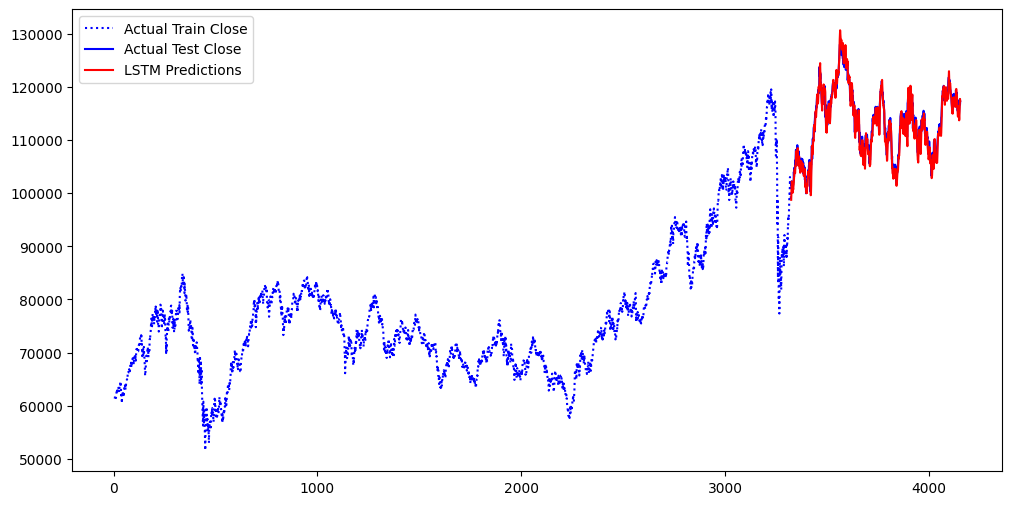

In [ ]:
 #Inverse transform both train and test data
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Create a time index for plotting
time_index_train = range(len(data) - len(testY) - len(trainY), len(data) - len(testY))
time_index_test = range(len(data) - len(testY), len(data))

# Plot all true values and the predictions with different colors
plt.figure(figsize=(12, 6))
plt.plot(time_index_train, trainY, label='Actual Train Close', color='blue', linestyle='dotted')
plt.plot(time_index_test, testY, label='Actual Test Close', color='blue')
plt.plot(time_index_test, lstm_predictions, label='LSTM Predictions', color='red')
plt.legend()
plt.show()

In [ ]:

lstm_mse = mean_squared_error(testY, lstm_predictions)

# Compare the models using Mean Squared Error

print("LSTM Model RMSE: ", np.sqrt(lstm_mse))


LSTM Model RMSE:  1383.2537475207412


In [ ]:
# Calculate the Mean Absolute Percentage Error (MAPE) for each model
def calculate_mape(true_values, predicted_values):
    abs_percentage_errors = np.abs((true_values - predicted_values) / true_values)
    mape = np.mean(abs_percentage_errors) * 100  # Convert to percentage
    return mape

lstm_mape = calculate_mape(testY, lstm_predictions)

# Compare the models using Mean Absolute Percentage Error
print("LSTM Model MAPE: {:.2f}%".format(lstm_mape))



LSTM Model MAPE: 0.96%


In [ ]:
def calculate_mae(true_values, predicted_values):
    abs_errors = np.abs(true_values - predicted_values)
    mae = np.mean(abs_errors)
    return mae


lstm_mae = calculate_mae(testY, lstm_predictions)


# Compare the models using Mean Absolute Percentage Error

print("LSTM Model MAE: {:.2f}".format(lstm_mae))


LSTM Model MAE: 1083.30


In [ ]:
# Calculate the MASE for each model
def calculate_mase(model_mae, baseline_mae):
    mase = model_mae / baseline_mae
    return mase

lstm_mase = calculate_mase(lstm_mae, 17652.17)


print("LSTM Model MASE: {:.2f}".format(lstm_mase))

LSTM Model MASE: 0.06


In [ ]:
# Assuming gru_predictions is your NumPy array
lstm_predictions = lstm_predictions.reshape(-1, 1)  # Reshape the array to have one column

# Create a DataFrame
df = pd.DataFrame(data=lstm_predictions, columns=['LSTM_Predictions'])

# Save the DataFrame to a CSV file
df.to_csv('lstm_predictions.csv', index=False)

In [ ]:
# Assuming gru_predictions is your NumPy array
trainY_predictions = trainY

# Create a DataFrame
df = pd.DataFrame(data=trainY_predictions, columns=['trainY_predictions'])

# Save the DataFrame to a CSV file
df.to_csv('trainY_predictions.csv', index=False)

In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2 = yf.download('^BVSP', '2007-01-01', '2023-09-22')
data2= data2[['Close']]
data2

last_60_days = data2[-look_back:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = X_test.reshape(-1,1,X_test.shape[1])
pred_price = lstm_model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 78ms/step
[[119634.73]]


In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2 = yf.download('^BVSP', '2023-09-23', '2023-09-26')
data2= data2[['Close']]
data2

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2023-09-25,115925.0
